<a href="https://colab.research.google.com/github/iamfaham/cuda-kernel-inference-profiler/blob/main/cuda_kernel_inference_profiler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Inference Efficiency Analyzer
**Goal:** profile a decoder-only Transformer in PyTorch, analyze CUDA kernel hotspots & memory, and surface optimization suggestions (fusion, precision, attention kernels, batching).

**What you’ll get:**
- Kernel/Op-level latency & memory tables (CUDA + CPU)
- Aggregated bar charts of top bottlenecks
- A simple, heuristic **optimizer hint engine**
- Optional `torch.compile` baseline comparison
- A Chrome trace file you can open in `chrome://tracing`


In [ ]:
!pip install transformers datasets accelerate --quiet

import os, time, gc, json, math
from dataclasses import dataclass
from typing import Dict, List, Tuple

import torch
from torch.profiler import profile, ProfilerActivity, record_function
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

print(torch.__version__)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


2.8.0+cu126
Device: cuda


## Cleanup & Utilities
We’ll add helpers to clear CUDA memory, time steps, and plot simple bar charts.


In [ ]:
def clean_env():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()
    print("🧹 Cleaned CUDA caches & GC complete.")

def now_mb():
    return (torch.cuda.memory_allocated() / (1024**2)) if torch.cuda.is_available() else 0.0

def peak_mb():
    return (torch.cuda.max_memory_allocated() / (1024**2)) if torch.cuda.is_available() else 0.0

def barh(names, values, title, xlabel):
    order = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
    names = [names[i] for i in order][:15]
    values = [values[i] for i in order][:15]
    plt.figure(figsize=(10,6))
    plt.barh(names[::-1], values[::-1])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()


## Load a Small Decoder-Only Model
We’ll use **OPT-125M** to keep profiling lightweight on a T4.  
Decoder-only models require **left padding** for generation.


In [ ]:
clean_env()

model_name = "facebook/opt-125m"  # small & fast to profile
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Left padding for decoder-only models
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16 if device == "cuda" else torch.float32,
).to(device)
model.config.use_cache = True

print("Tokenizer padding_side:", tokenizer.padding_side)
print("Model dtype:", next(model.parameters()).dtype)
print(f"GPU mem after load: {now_mb():.1f} MB")


🧹 Cleaned CUDA caches & GC complete.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/251M [00:00<?, ?B/s]

Tokenizer padding_side: left
Model dtype: torch.float16
GPU mem after load: 245.5 MB


## Real Evaluation Inputs
We pull lines from **WikiText-2 (test split)** and filter short/empty lines.  
We’ll use these for both **generation** (latency) and **teacher-forced forward** (PPL if needed).


In [ ]:
ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
texts = [t for t in ds["text"] if len(t.strip()) > 20][:256]  # keep it small but real

BATCH = 8
MAX_LEN = 128
NEW_TOKENS = 200

enc = tokenizer(texts[:BATCH], padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
enc = {k: v.to(device) for k, v in enc.items()}
print({k: v.shape for k,v in enc.items()})


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

{'input_ids': torch.Size([8, 128]), 'attention_mask': torch.Size([8, 128])}


## Profiling Plan
We’ll profile **generation** (which stresses attention + KV cache) using `torch.profiler`:
- Activities: **CUDA** & **CPU**
- Shapes & memory captured
- Export a Chrome trace (`trace.json`) for deep dive


In [ ]:
@dataclass
class ProfileResult:
    table_text: str
    op_stats: List[Tuple[str, float, float, int]]  # (name, cuda_ms, cpu_ms, calls)

def run_profiler(model, enc, new_tokens=NEW_TOKENS, trace_path="trace.json") -> ProfileResult:
    if device == "cuda":
        torch.cuda.synchronize()
    clean_env()

    schedule = torch.profiler.schedule(wait=0, warmup=1, active=1, repeat=1)
    activities = [ProfilerActivity.CPU]
    if device == "cuda":
        activities.append(ProfilerActivity.CUDA)

    with profile(
        schedule=schedule,
        activities=activities,
        record_shapes=True,
        profile_memory=True,
        with_stack=False,
        on_trace_ready=torch.profiler.tensorboard_trace_handler("."),  # also drops TB traces
    ) as prof:
        # warmup
        with torch.no_grad():
            _ = model.generate(**enc, max_new_tokens=8)
        # active
        prof.step()
        with torch.no_grad():
            _ = model.generate(**enc, max_new_tokens=new_tokens)
        prof.step()

    # save chrome trace
    try:
        prof.export_chrome_trace(trace_path)
        print(f"📁 Chrome trace saved to: {os.path.abspath(trace_path)}")
    except Exception as e:
        print("Trace export skipped:", e)

    # aggregate
    events = prof.key_averages()
    rows = []
    for e in events:
        cuda_ms = getattr(e, "cuda_time_total", 0.0) / 1000.0
        cpu_ms = getattr(e, "cpu_time_total", 0.0) / 1000.0
        rows.append((e.key, cuda_ms, cpu_ms, e.count))

    table = events.table(sort_by="cuda_time_total" if device=="cuda" else "cpu_time_total",
                         row_limit=30)
    print(table)

    return ProfileResult(table, rows)

prof_res = run_profiler(model, enc)


🧹 Cleaned CUDA caches & GC complete.
Trace export skipped: Trace is already saved.
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          ProfilerStep*         0.00%       0.000us         0.00%       0.000us       0.000us        7.663s       768.39%

## Top Operator Bottlenecks
We aggregate time per operator and plot the top contributors by CUDA time (or CPU time if no GPU).


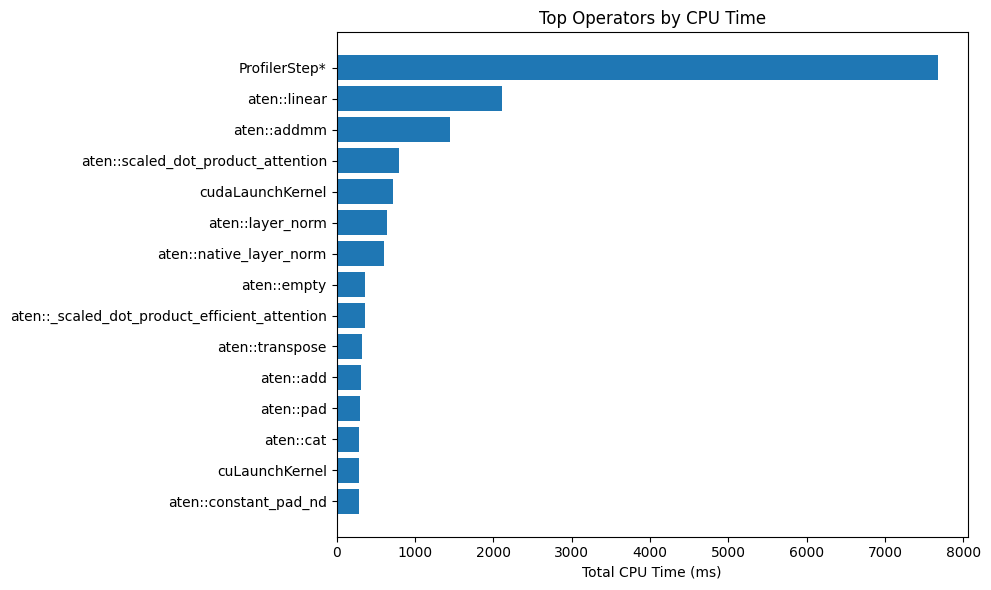

/tmp/ipython-input-279025179.py:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


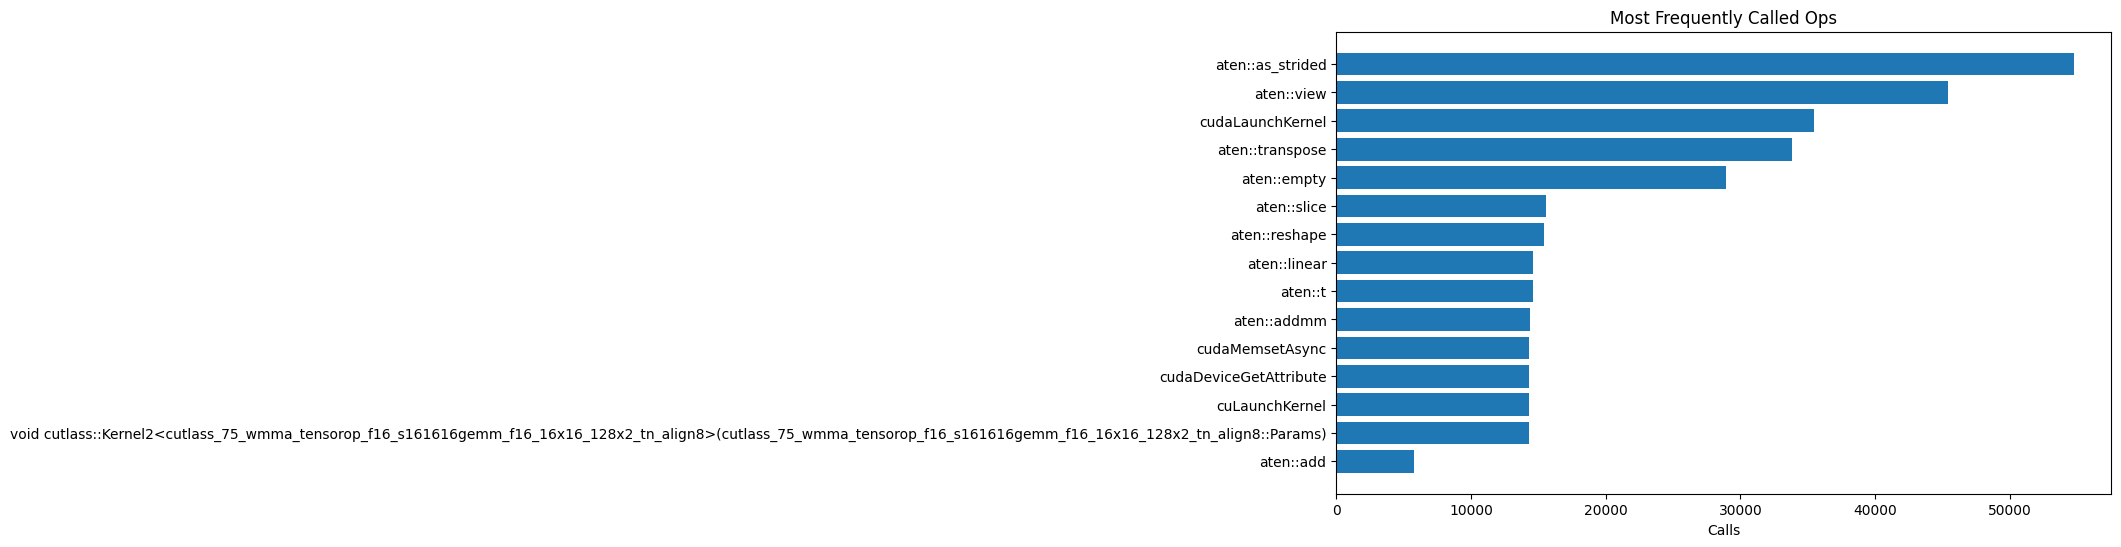

Peak GPU memory during profiling: 390.2 MB


In [ ]:
names = [r[0] for r in prof_res.op_stats]
cuda_ms = [r[1] for r in prof_res.op_stats]
cpu_ms  = [r[2] for r in prof_res.op_stats]
calls   = [r[3] for r in prof_res.op_stats]

if device == "cuda" and any(v > 0 for v in cuda_ms):
    barh(names, cuda_ms, "Top Operators by CUDA Time", "Total CUDA Time (ms)")
else:
    barh(names, cpu_ms, "Top Operators by CPU Time", "Total CPU Time (ms)")

barh(names, calls, "Most Frequently Called Ops", "Calls")
print(f"Peak GPU memory during profiling: {peak_mb():.1f} MB")


## Bottleneck Analyzer (Heuristic)
We use operator names to tag likely **memory-bound** vs **compute-bound** spots, and suggest optimizations:
- Attention / softmax / layernorm → memory-bound → try FlashAttention, fused norms
- MatMul / GEMM → compute-bound → ensure FP16/BF16, larger batch, kernel autotune
- Small elementwise chains → fuse ops (bias+activation, etc.)


In [ ]:
# Filter out low-level allocator/copy ops that clutter results
IGNORED = (
    "empty", "copy_", "to", "cudaMemcpy", "empty_strided",
    "view", "detach", "ProfilerStep", "lift_fresh",
    "as_strided", "unsqueeze", "fill_", "isin", "StreamSynchronize"
)

MEMORY_BOUND_HINTS = (
    "scaled_dot_product_attention", "softmax",
    "native_layer_norm", "layer_norm",
    "index", "gather", "scatter", "embedding"
)
COMPUTE_BOUND_HINTS = ("mm", "addmm", "bmm", "matmul", "linear")

def suggest_optimizations(op_rows: list[tuple[str,float,float,int]], top_k=20):
    # rank by CUDA time if available else CPU
    ordered = sorted(op_rows, key=lambda r: r[1] if device=="cuda" else r[2], reverse=True)
    ordered = [r for r in ordered if not any(ig in r[0] for ig in IGNORED)][:top_k]

    suggestions = []
    for name, c_ms, p_ms, cnt in ordered:
        lower = name.lower()
        if any(h in lower for h in MEMORY_BOUND_HINTS):
            suggestions.append((
                name, "Likely memory-bound",
                [
                    "Try FlashAttention2 or scaled_dot_product_attention backend.",
                    "Fuse LayerNorm + residual add using Apex or FusedLayerNorm.",
                    "Increase sequence/batch length to improve arithmetic intensity.",
                ]
            ))
        elif any(h in lower for h in COMPUTE_BOUND_HINTS):
            suggestions.append((
                name, "Likely compute-bound",
                [
                    "Enable autocast (FP16/BF16) to hit Tensor Cores.",
                    "Consider TensorRT or torch.compile for kernel fusion.",
                    "Check GEMM autotune or cudnn.benchmark=True.",
                ]
            ))
        else:
            suggestions.append((
                name, "Mixed/unknown",
                [
                    "Inspect with chrome://tracing for kernel launch overlap.",
                    "Consider torch.compile to merge small kernels.",
                ]
            ))
    return suggestions

# 🔍 Run updated analyzer
hints = suggest_optimizations(prof_res.op_stats, top_k=25)
print("=== Refined Optimization Suggestions ===")
for name, kind, recs in hints:
    print(f"\n• {name}  →  {kind}")
    for r in recs:
        print(f"  - {r}")


=== Refined Optimization Suggestions ===

• cudaLaunchKernel  →  Mixed/unknown
  - Inspect with chrome://tracing for kernel launch overlap.
  - Consider torch.compile to merge small kernels.

• aten::eq  →  Mixed/unknown
  - Inspect with chrome://tracing for kernel launch overlap.
  - Consider torch.compile to merge small kernels.

• aten::any  →  Mixed/unknown
  - Inspect with chrome://tracing for kernel launch overlap.
  - Consider torch.compile to merge small kernels.

• aten::is_nonzero  →  Mixed/unknown
  - Inspect with chrome://tracing for kernel launch overlap.
  - Consider torch.compile to merge small kernels.

• aten::item  →  Mixed/unknown
  - Inspect with chrome://tracing for kernel launch overlap.
  - Consider torch.compile to merge small kernels.

• aten::_local_scalar_dense  →  Mixed/unknown
  - Inspect with chrome://tracing for kernel launch overlap.
  - Consider torch.compile to merge small kernels.

• aten::lt  →  Mixed/unknown
  - Inspect with chrome://tracing for ker

## `torch.compile` Speed Check
We wrap the model with `torch.compile` (Inductor) to test easy graph-level fusion & kernel scheduling benefits, then reprofile briefly.


In [ ]:
if hasattr(torch, "compile"):
    clean_env()
    compiled = torch.compile(model)
    # quick warmup + timing on same batch
    with torch.no_grad():
        _ = compiled.generate(**enc, max_new_tokens=16)
    if device == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        _ = compiled.generate(**enc, max_new_tokens=64)
    if device == "cuda":
        torch.cuda.synchronize()
    t1 = time.time()
    print(f"⏱️ torch.compile quick latency (64 tokens): {(t1 - t0):.3f}s | peak mem: {peak_mb():.1f} MB")
else:
    print("torch.compile not available on this PyTorch build.")


🧹 Cleaned CUDA caches & GC complete.
⏱️ torch.compile quick latency (64 tokens): 1.203s | peak mem: 390.2 MB


## Trace & Summary
- We saved a Chrome trace (`trace.json`) — open it via `chrome://tracing`.
- Below is a compact summary for your README/report.


In [ ]:
top_by = 1 if device=="cuda" else 2  # index: cuda_ms or cpu_ms
tops = sorted(prof_res.op_stats, key=lambda r: r[top_by], reverse=True)[:10]

summary = {
    "device": device,
    "batch": BATCH,
    "max_len": MAX_LEN,
    "new_tokens": NEW_TOKENS,
    "peak_mem_MB": round(peak_mb(), 1),
    "top_ops": [
        {"op": n, "cuda_ms": round(c,2), "cpu_ms": round(p,2), "calls": int(k)}
        for (n,c,p,k) in tops
    ],
}
print(json.dumps(summary, indent=2))


{
  "device": "cuda",
  "batch": 8,
  "max_len": 128,
  "new_tokens": 200,
  "peak_mem_MB": 390.2,
  "top_ops": [
    {
      "op": "ProfilerStep*",
      "cuda_ms": 0.0,
      "cpu_ms": 7672.55,
      "calls": 1
    },
    {
      "op": "aten::empty",
      "cuda_ms": 0.0,
      "cpu_ms": 363.94,
      "calls": 28929
    },
    {
      "op": "aten::to",
      "cuda_ms": 0.0,
      "cpu_ms": 21.22,
      "calls": 1232
    },
    {
      "op": "aten::_to_copy",
      "cuda_ms": 0.0,
      "cpu_ms": 17.82,
      "calls": 228
    },
    {
      "op": "aten::empty_strided",
      "cuda_ms": 0.0,
      "cpu_ms": 5.45,
      "calls": 428
    },
    {
      "op": "aten::copy_",
      "cuda_ms": 0.0,
      "cpu_ms": 128.78,
      "calls": 3532
    },
    {
      "op": "cudaMemcpyAsync",
      "cuda_ms": 0.0,
      "cpu_ms": 26.09,
      "calls": 1411
    },
    {
      "op": "ProfilerStep*",
      "cuda_ms": 0.0,
      "cpu_ms": 0.0,
      "calls": 1
    },
    {
      "op": "Memcpy HtoD (Page